In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("Downloads//calories.csv")
df = df.drop(columns=['User_ID'])

X = df.drop(columns=['Calories'])  
y = df['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

categorical_cols = ['Gender']
numeric_cols = ['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight', 'Height']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_cols),  
        ('categorical', OneHotEncoder(), categorical_cols),  
    ]
)

# Define pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

# Hyperparameter tuning
param_grid = {
    'rf__n_estimators': [100, 200, 300],  
    'rf__max_depth': [10, 20, None],  
    'rf__min_samples_split': [2, 5, 10, 20],  
    'rf__min_samples_leaf': [1, 2, 5, 10],  
    'rf__bootstrap': [True, False]  # Try both bootstrap and no bootstrap sampling
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best cross-validation test MSE:", abs(grid_search.best_score_))

# Evaluate model
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Train MSE:", train_mse)
print("Train R^2:", r2_train)

y_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print('Test MSE:', mse_test)
print('Test R^2:', r2_test)


Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best cross-validation test MSE: 9.185842230330469
Train MSE: 1.1291248221963508
Train R^2: 0.9997079220229397
Test MSE: 6.924429024793658
Test R^2: 0.998284245094504


C:\Users\sadin\AppData\Local\Temp\ipykernel_24504\2952748028.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance, y=sorted_names, palette='viridis')


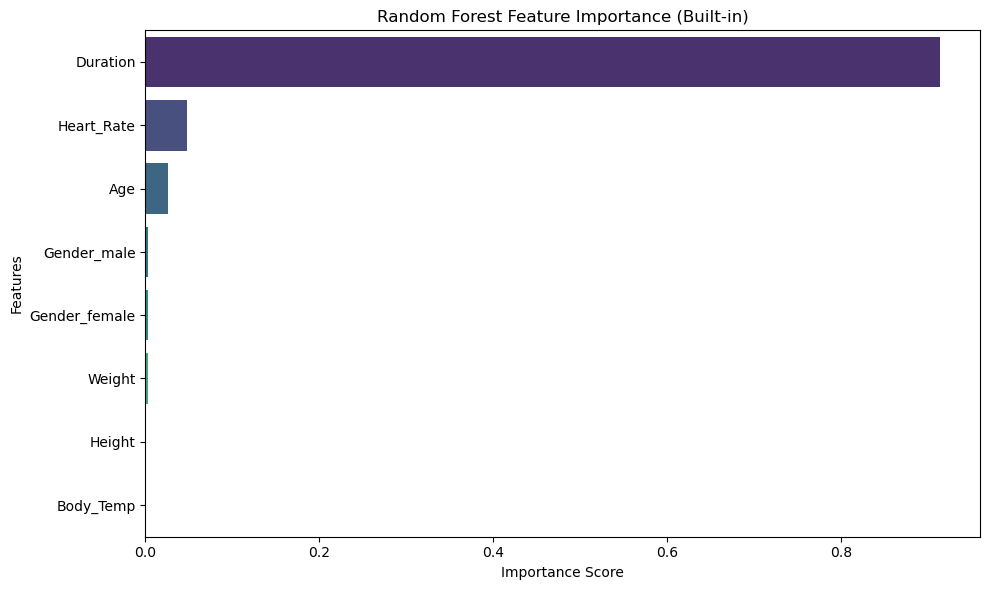

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

preprocessor = best_model.named_steps['preprocessor']
rf_model = best_model.named_steps['rf']

# Get feature names after preprocessing (automatically handles categorical one-hot encoding)
feature_names = numeric_cols + list(
    preprocessor.named_transformers_['categorical']
    .get_feature_names_out(categorical_cols)
)

# Get feature importances from Random Forest
importance = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(importance)[::-1]  # Descending order
sorted_names = np.array(feature_names)[sorted_idx]
sorted_importance = importance[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_names, palette='viridis')
plt.title("Random Forest Feature Importance (Built-in)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.svm import SVR

preprocessor_svr = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_cols),  
        ('categorical', OneHotEncoder(), categorical_cols),  
    ]
)

# Define pipeline
pipeline_svr = Pipeline([
    ('preprocessor', preprocessor_svr),
    ('svr', SVR(kernel='rbf'))
])

param_grid_svr = {
    'svr__C': [0.01, 0.1, 1, 10, 100],        
    'svr__epsilon': [0.01, 0.1, 0.5, 1, 2], 
    'svr__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']  
}

grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)  

print("Best Parameters:", grid_search_svr.best_params_)
print("Best cross-validation test MSE:", abs(grid_search_svr.best_score_))

best_model_svr = grid_search_svr.best_estimator_
y_train_pred = best_model_svr.predict(X_train)

train_mse = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Train MSE:", train_mse)
print("Train R^2:", r2_train)

y_pred = best_model_svr.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print('Test MSE:', mse_test)
print('Test R^2:', r2_test)

Best Parameters: {'svr__C': 100, 'svr__epsilon': 0.01, 'svr__gamma': 0.1}
Best cross-validation test MSE: 0.26326675849593956
Train MSE: 0.16817783957908472
Train R^2: 0.999956496356997
Test MSE: 0.15368040719324713
Test R^2: 0.9999619206274516


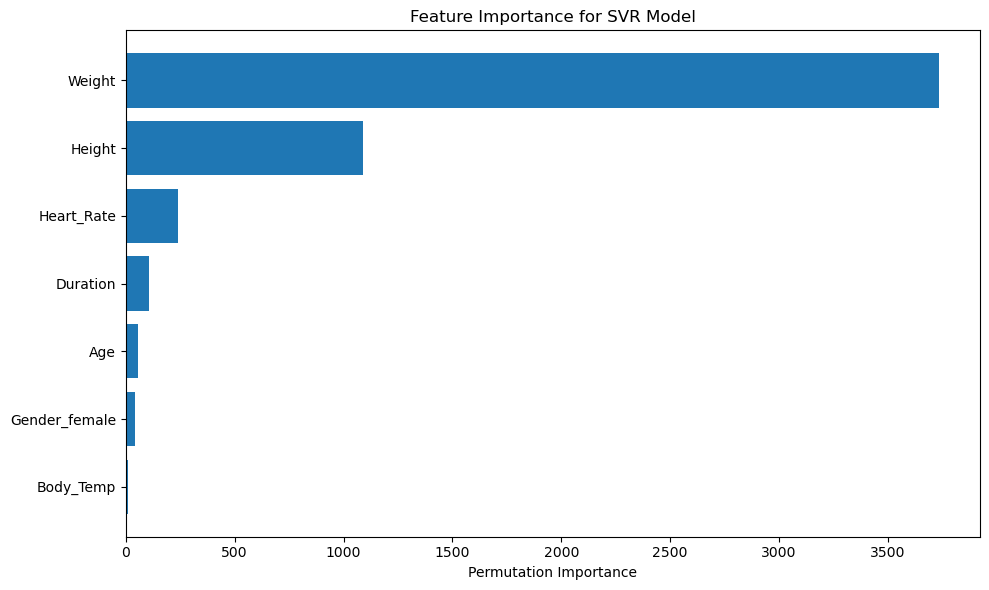

In [8]:
from sklearn.inspection import permutation_importance

# Get categorical feature names (after encoding)
categorical_encoder = best_model_svr.named_steps['preprocessor'].named_transformers_['categorical']
categorical_features = categorical_encoder.get_feature_names_out(categorical_cols)

# Combine all features
all_features = np.concatenate([numeric_cols, categorical_features])

# Compute permutation importance
result = permutation_importance(
    best_model_svr, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(all_features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for SVR Model")
plt.tight_layout()
plt.show()

In [9]:
all_features

array(['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight', 'Height',
       'Gender_female', 'Gender_male'], dtype=object)